# Distribution of backgrounds, control sample and neutrino box in RA and Dec

### May 2, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/SourceSearch")
# import deDisperse_util as util
import matplotlib.colors as colors

my_path_plots = os.path.abspath("./plots/")
import re


Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Read from file

In [4]:
bkgFolder = "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_SourceSearch/data_util/"

In [120]:
combined =[]
for config in range(1,6):
#     print(config)
    bkg = pd.read_pickle(bkgFolder+"bkgDistribution_%i.pkl"%config)
    combined.append(bkg)
    
allBkg = pd.concat(combined)
allBkg = allBkg.loc[allBkg.RA>0]

In [170]:
def convertThetatoRange(theta):
    theta = np.radians(theta)
    return np.degrees(np.mod((theta) ,np.pi))
allBkg["theta_Conv"] = convertThetatoRange(allBkg.Dec)

No handles with labels found to put in legend.


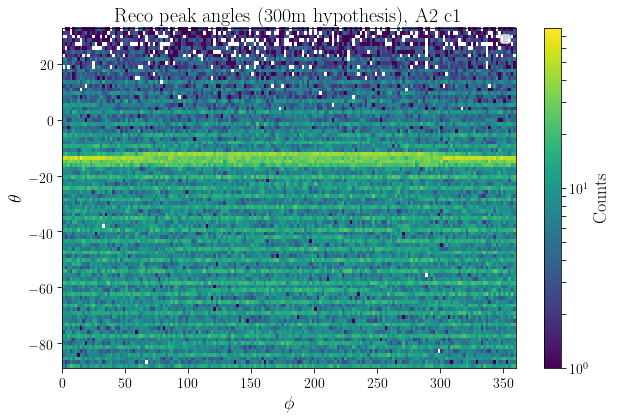

In [171]:
plt.figure(figsize=(9,6))
# plt.hist2d(allBkg.phi,theta_Conv, bins=[int(360/2),int(180/2)]);
plt.hist2d(allBkg.RA,allBkg.Dec, bins=[int(360/2),int(180/2)],norm = mpl.colors.LogNorm());

plt.colorbar(label="Counts")
# plt.scatter(-25.02,-19.53, marker="<", s = 50, color="red", label="CP5")
# plt.scatter(65.19,9.76, marker=">", s = 50, color="red", label="CP6")
# plt.scatter(-106.9,38, marker="X", s = 100, color="violet", label="ICL")
# plt.scatter(-84.9,38, marker="D", s = 100, color="orange", label="SP")
# plt.scatter(-94.8,38, marker="x", s = 100, color="firebrick", label="WT3")


plt.xlabel("$\phi$")
plt.ylabel("$\\theta$")
plt.title("Reco peak angles (300m hypothesis), A2 c1")
plt.tight_layout()
# plt.grid(alpha=0.6, color = "w", ls = "--")
# plt.ylim(-90,50)
plt.legend(ncol=3)
# plt.savefig("./A2_c1_bkgDistribution.png", dpi = 200)

## Mollweide proj.

In [172]:
import healpy as hp

In [173]:
def cat2hpx(phi, theta, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

#     if radec:
#         eq = SkyCoord(lon, lat, 'icrs', unit='deg')
#         l, b = eq.galactic.l.value, eq.galactic.b.value
#     else:
#         l, b = lon, lat

    # conver to theta, phi
#     theta = np.radians(90. - b)
#     phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

In [213]:
DecBox = allBkg.loc[allBkg.neutrinoBox==1].theta_Conv
RABox = allBkg.loc[allBkg.neutrinoBox==1].RA
hpx_map = cat2hpx(-np.radians(RABox),np.radians(DecBox), 35)


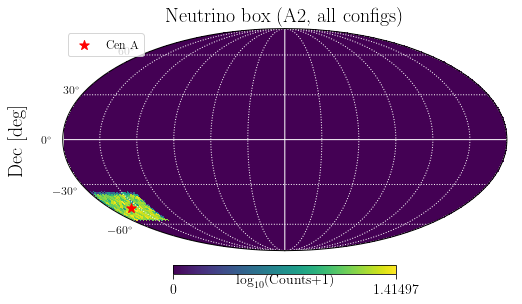

In [214]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
plt.sca(ax)
title = r'sky sca'
themap = hp.mollview(np.log10(hpx_map+1),hold=True, title=title,unit=r'$\log_{10}$(Counts+1)',notext=True )
hp.graticule(color = "white",verbose=True)
ax.tick_params(direction='out', length=6, width=2, colors='r')
plt.title("Neutrino box (A2, all configs)")
hp.projscatter(-0.7508+np.pi,np.radians(360-201.36506288), color='red',s = 100, marker='*', label='Cen A')

#PLot tick labels
plt.text(-2.2,0., r"$0^\circ$", ha="left", va="center")
plt.text(-2.0,0.45, r"$30^\circ$", ha="left", va="center")
plt.text(-1.5,0.8, r"$60^\circ$", ha="left", va="center")
plt.text(-2.1,-0.45, r"$-30^\circ$", ha="left", va="center")
plt.text(-1.6,-0.8, r"$-60^\circ$", ha="left", va="center")
plt.text(-2.5,0., r"Dec [deg]", ha="left", va="center", rotation=90, fontsize=20)


plt.legend()
plt.tight_layout()
plt.savefig("./bkgDist_mollview_Allconfig_nuBox.pdf")

In [215]:
DecBox = allBkg.loc[(allBkg.controlSample==1) & (allBkg.neutrinoBox==0)].theta_Conv
RABox = allBkg.loc[(allBkg.controlSample==1) & (allBkg.neutrinoBox==0)].RA
hpx_map = cat2hpx(-np.radians(RABox),np.radians(DecBox), 35)


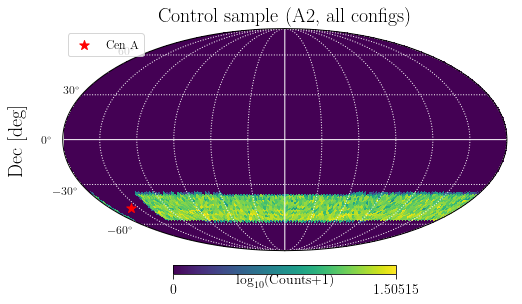

In [216]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
plt.sca(ax)
title = r'sky sca'
themap = hp.mollview(np.log10(hpx_map+1),hold=True, title=title,unit=r'$\log_{10}$(Counts+1)',notext=True )
hp.graticule(color = "white",verbose=True)
ax.tick_params(direction='out', length=6, width=2, colors='r')
plt.title("Control sample (A2, all configs)")
hp.projscatter(-0.7508+np.pi,np.radians(360-201.36506288), color='red',s = 100, marker='*', label='Cen A')

#PLot tick labels
plt.text(-2.2,0., r"$0^\circ$", ha="left", va="center")
plt.text(-2.0,0.45, r"$30^\circ$", ha="left", va="center")
plt.text(-1.5,0.8, r"$60^\circ$", ha="left", va="center")
plt.text(-2.1,-0.45, r"$-30^\circ$", ha="left", va="center")
plt.text(-1.6,-0.8, r"$-60^\circ$", ha="left", va="center")
plt.text(-2.5,0., r"Dec [deg]", ha="left", va="center", rotation=90, fontsize=20)


plt.legend()
plt.tight_layout()
plt.savefig("./bkgDist_mollview_Allconfig_ControlSample.pdf")

In [49]:
allBkg

theta  phi    unixTime          RA        Dec  neutrinoBox  \
0        -49 -173  1379237038   37.727665 -18.034033            0   
1        -18 -170  1379237362  193.955963 -78.953088            0   
2        -52   32  1379237598  246.907183 -70.990815            0   
3        -79   82  1379237755  297.696424 -20.038908            0   
4        -43  163  1379239272  354.061335 -54.056035            0   
...      ...  ...         ...         ...        ...          ...   
74321    -44   31  1466125804   74.536093 -40.026895            0   
74322    -44  -56  1466125809  116.583584 -49.938039            0   
74323     20 -167  1466125830  169.691659 -83.874255            0   
74324    -42 -172  1466125936   54.013276 -15.066908            0   
74325    -40  -83  1466126024  129.788382 -77.914560            0   

       controlSample  crossCheck  theta_Conv  
0                  0           0  161.965967  
1                  0           0  101.046912  
2                  0           0  109.009185  
3                  0           0  159.961092  
4                  0           0  125.943965  
...              ...         ...         ...  
74321              1           0  139.973105  
74322              1           0  130.061961  
74323              0           0   96.125745  
74324              0           0  164.933092  
74325              0           0  102.085440  

[146230 rows x 9 columns]

(array([15502., 15248., 16427., 15815., 16545., 18870., 26990., 10350.,
         7071.,  3412.]),
 array([-89.12528449, -76.90109882, -64.67691315, -52.45272747,
        -40.2285418 , -28.00435612, -15.78017045,  -3.55598477,
          8.6682009 ,  20.89238658,  33.11657225]),
 <a list of 10 Patch objects>)

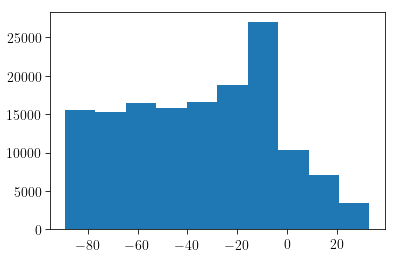

In [19]:
plt.hist(allBkg.Dec)